In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from src.source_selector import Recommender, InfluenceModel, EdgeSplitter, PaperNLP
from src.graphing import AuthorNetwork
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import train_test_split
from src.component import ComponentCreator
from src.to_gexf import pd_to_gexf

import matplotlib.pyplot as plt

In [2]:
client = MongoClient()
papers = client.capstone.papers

In [3]:
comp_creator = ComponentCreator(collection=papers)

In [4]:
# retracted = pd.read_json('data/retracted_articles0', lines=-1)['id'].values

In [5]:
# E,X = comp_creator.edge_construct(retracted.iloc)
# E['retracted_src'] = E['src'].apply(lambda x: x in retracted)

In [6]:
# X['retracted'] = X['_id'].apply(lambda x: 1 if x in retracted else 0)

In [7]:
# X['id'] = X['_id']
# E['id'] = np.arange(len(E))

In [30]:
# E,X = comp_creator.edge_construct(retracted[np.random.choice(len(retracted), size=10)], depth=2, lim=10000)
E,X = comp_creator.random_construct()
# E['retracted_src'] = E['src'].apply(lambda x: x in retracted)
# X['retracted'] = X['_id'].apply(lambda x: 1 if x in retracted else 0)

In [45]:
E,X,y = comp_creator.edge_construct(10, 4, get_influence=True, lim=1000)

In [46]:
X['id'] = X['_id']
E['id'] = np.arange(len(E))
len(X), len(E)

(2432, 3986)

In [10]:
# edges = {Edge(network[src], network[dst]) for _, (src,dst) 
#          in E.loc[:, ['src','dst']].iterrows()
#          if src in network and dst in network}

In [11]:
# pd_to_gexf(edges=E,nodes=X, path='retracted_full.gexf', node_attr={'year':'float','retracted':'integer'})

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix
class Node():
    def __init__(self, x):
        self.id = x['_id'] if '_id' in x else '-1'
        self.authors = (set((itm['ids'][0] if itm['ids'] else -1) 
                            if isinstance(itm, dict) else itm
                            for itm in x['authors'])
                        if 'authors' in x else set())
        self.in_ = set(x['inCitations']) if 'inCitations' in x else set()
        self.out_ = set(x['outCitations']) if 'outCitations' in x else set()
        self.year = x['year'] if 'inCitations' in x else 2018
        self.title = x['title'] if 'title' in x else ''
        self.abstract = x['paperAbstract'] if 'paperAbstract' in x else ''
        self.topics = set(x['entities']) if 'entities' in x else set()
        
    def __repr__(self):
        return f'<{self.id}>'
    
    def to_string(self):
        return f'''
            {self.title}
            {str(self.year).center(len(self.title))}
            
        {self.abstract}
        
        Tags: {', '.join(self.topics)}
        '''
    
    def to_dict(self):
        return {
            'id':self.id,
            'authors': self.authors,
            'inCitations': self.in_,
            'outCitations': self.out_,
            'year': self.year,
            'title': self.title,
            'paperAbstract': self.abstract,
            'entities': self.topics
        }
        
    @property
    def n_authors(self):
        return len(self.authors)
    
    @staticmethod
    def new_node(**kwargs):
        return Node(kwargs)
        
class Edge():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        
    def __repr__(self):
        return f'Edge(src={self.src}, dst={self.dst})'
    
    def similarity(self, attr):
        src_val = getattr(self.src, attr)
        dst_val = getattr(self.dst, attr)
        src_val = src_val if isinstance(src_val, str) else ' '.join(src_val)
        dst_val = dst_val if isinstance(dst_val, str) else ' '.join(dst_val)
        if len(src_val) == 0 or len(dst_val) == 0:
            return 0
        tfidf = TfidfVectorizer()
        tfidf.fit([src_val, dst_val])
        u,v = tfidf.transform([src_val, dst_val])
        similarity = (u @ v.T)
        return similarity.data[0] if similarity.count_nonzero() > 0 else 0
            
    @property
    def topics(self):
        return self.src.topics & self.dst.topics
    
    @property
    def age(self):
        return self.dst.year - self.src.year
    
class Network():
    def __init__(self, nodes=[]):
        self.nodes = {}
        self.edges = set()
        self._construct(nodes)
        self._tfidf = {}
        self._node_nlp = {}
        
    def _construct(self, nodes):
        for node in nodes:
            self.nodes[node.id] = node
            for src in node.in_:
                if src in self:
                    self.edges |= {(src, node.id)} 
            for dst in node.out_:
                if dst in self:
                    self.edges |= {(node.id, dst)}
        
    def __getitem__(self, key):
        return self.nodes[key]
    
    def __iter__(self):
        for key in self.nodes:
            yield key

    def __contains__(self, key):
        return key in self.nodes
    
    def _fit_nlp(self, attr):
        self._tfidf[attr] = TfidfVectorizer(max_features=500)
        self._tfidf[attr].fit(getattr(node, attr) if isinstance(getattr(node, attr), str)
                              else ' '.join(getattr(node, attr))
                              for node in self.nodes.values())
        if attr in self._node_nlp:
            del self._node_nlp[attr]
        
    def _run_nlp(self, attr):
        for attr in self._tfidf:
            for node in  self.nodes.values():
                node_attr = getattr(node, attr)
                if attr not in self._node_nlp:
                    self._node_nlp[attr] = {}
                if node.id not in self._node_nlp[attr]:
                    self._node_nlp[attr][node.id] = self._tfidf[attr].transform([
                        node_attr if isinstance(node_attr, str)
                        else ' '.join(node_attr)])
       
    def compare(self, n, m, attr=None):
        if attr is None:
            return n == m
        n_attr, m_attr = (getattr(self[x], attr) for x in (n,m))
        if attr in self._tfidf:
            n_, m_ = self._node_nlp[attr][n], self._node_nlp[attr][m]
            similarity = (n_ @ m_.T)
            return similarity.data[0] if similarity.count_nonzero() > 0 else 0
        
        if isinstance(n_attr, set):
            return len(n_attr & m_attr)
        
        if isinstance(n_attr, (int, float)):
            return abs(n_attr - m_attr)
        
        return n_attr == m_attr
    
    def compare_many(self, n, m, attr):
        n_attr, m_attr = [np.array([getattr(self[x], attr) for x in u]) for u in (m,n)]
        if n_attr.dtype.kind in 'fi':
            return abs(n_attr - m_attr)
        else:
            return np.array([
             self.compare(x,y, attr) for (x,y) in zip(n,m)   
            ])
        
    def adj_matrix(self, idx=False):
        n_nodes = len(self.nodes)
        idx = dict(zip(self.nodes, range(n_nodes)))
        r,c,d = zip(*((idx[u], idx[v], 1) 
              for u,v in self.edges
              if u in idx and v in idx))
        M = coo_matrix((d, (r,c)), shape=(n_nodes, n_nodes), dtype=int)
        return M if not idx else (M, idx)
    
    def sim_matrix(self, attr):
        n_nodes = len(self.nodes)
        idx = dict(zip(self.nodes, range(n_nodes)))
        r,c,d = zip(*((idx[u], idx[v], self.compare(u,v, attr)) 
              for u,v in self.edges
              if u in idx and v in idx))
        M = coo_matrix((d, (r,c)), shape=(n_nodes, n_nodes), dtype=int)
        return M
        
    def add_nodes(self, nodes):
        self._construct(nodes)
    
    def remove_nodes(self, nodes):
        for node in nodes:
            del self.nodes[node]
        
    def page_rank(self):
        pg_ranks = power_iteration(self.adj_matrix(), 50)
        return {node: rnk for node,rnk in zip(self.nodes.keys(), pg_ranks)}
    
    @property
    def shape(self):
        return f'(nodes x {len(self.nodes)}), (edges x {len(self.edges)})'
    
class Model():
    def __init__(self, base_estimator, attributes=[]):
        self.base_estimator = base_estimator
        self.attributes = attributes
        self._network = Network()
    
    def fit(self, X, y=None):
        nodes = {Node(x) for _, x in X.iterrows()}
        self._network = Network(nodes)
        for attr in ['topics','title','abstract']:
                self._network._fit_nlp(attr)
                self._network._run_nlp(attr)
        E,y = Splitter.create_edges(nodes, 5.0)
        self._fit(E,y)
        return self
    
    def _fit(self, E, y, n_passes=0):
        X = self._transform(E)
        self.base_estimator.fit(X, y)
        if 0 < n_passes: 
            y_ = []
            X_ = []
            for x in E[:,1]:
                recs,_ = self._recommend(x, 5)
                X_.extend([[rec, x] for rec in recs])
                y_.extend([1 if np.any([rec,x] == X) else 0 for rec in recs])
            X_ = np.array([x for x in X_ if x in E[y.astype(bool)]])
            y_ = np.zeros(len(X_))
            X_,y_ = np.concatenate((E, X_)), np.append(y, y_)
            self._fit(X_, y_, n_passes-1)
        
    def predict(self, X):
        X_ = self._transform(X)
        return self.base_estimator.predict(X_)
            
    def predict_proba(self, X):
        X_ = self._transform(X)
        return self.base_estimator.predict_proba(X_)
         
    def _transform(self, E):
        X_ = np.zeros((E.shape[0], len(self.attributes)))
        for i, attr in enumerate(self.attributes):
            X_[:, i] = self._network.compare_many(E[:,0], E[:,1], attr)
        X_[np.isnan(X_)] = 0
        return X_
    
    def _update_network(self, X):
        if isinstance(X, pd.DataFrame):
            self._network.add_nodes(Node(x) for _, x in X.iterrows())
        elif isinstance(X, (np.ndarray, list, tuple)):
            self._network.add_nodes(Node(x) for x in X)
        for attr in self._network._tfidf:
            self._network._run_nlp(attr) 
        
    def _recommend(self, x, k=6):
        if isinstance(x, dict):
            x = Node.new_node(**x)
        if isinstance(x, str):
            x = self._network[x]
        E = np.array([[src, x.id] for src in self._network])
        self._network.add_nodes([x])
        pred = self.predict_proba(E)[:, 1]
        sort_idxs = np.argsort(pred)[::-1]
        return (E[sort_idxs][:k, 0], pred[sort_idxs][:k])
    
    def recommend(self, k=6, **kwargs):
        for i, (_id, prb) in enumerate(zip(*self._recommend(kwargs, k))):
            print(f'Match Probability: {prb*100:0.1f}%')
            print(self._network[_id].to_string())
            if i + 1 != k:
                usr_input = input('Any key for next suggestion or "exit" to quit: ')
            if "exit" in usr_input.lower():
                break
            
    def _page_ranks(self, v):
        adj_mat, idx = self._network.adj_matrix(idx=True)
        pg_rank = power_iteration(adj_mat, 50)
        idxs = np.array([idx[u] for u in v])
        return pg_rank[idxs].ravel()
         
class Splitter():
    @staticmethod
    def split(X, random=0.0, **kwargs):
        X0, Xt = train_test_split(X, **kwargs)
        E0,y0 = Splitter.create_edges(X0, random=random)
        Et,yt = Splitter.create_edges(Xt, random=random)
        return X0,Xt, y0,yt, E0,Et
        
    @staticmethod
    def create_edges(X, random=0.0):
        if isinstance(X, pd.DataFrame):
            X = {Node(x) for _,x in X.iterrows()}
        return Splitter._construct_edges(X, int(random * len(X)))  
        
    @staticmethod
    def _construct_edges(nodes, n_random):
        edges = set()
        node_ids = {node.id for node in nodes}
        
        src_idxs=np.random.choice(np.arange(len(nodes)), n_random)
        dst_idxs=np.random.choice(np.arange(len(nodes)), n_random)

        rand_srcs = np.array(['' for _ in range(n_random)], dtype='O')
        rand_dsts = np.array(['' for _ in range(n_random)], dtype='O')
        for i, node in enumerate(nodes):
            src_match = (src_idxs == i)
            dst_match = (dst_idxs == i)
            if np.any(src_match):
                rand_srcs[src_match] = node.id
            if np.any(dst_match):
                rand_dsts[dst_match] = node.id
            for src in node.in_:
                if src in node_ids:
                    edges |= {(src, node.id)} 
            for dst in node.out_:
                if dst in node_ids:
                    edges |= {(node.id, dst)}
                    
        rand_E = np.array(list(zip(rand_srcs, rand_dsts)))
        E = np.array(list(edges))
        y = np.ones(len(E))
        rand_y = np.zeros(len(rand_E))
        E = np.append(E, rand_E, axis=0)
        y = np.append(y, rand_y, axis=0)
        return E,y
    
class Util():
    @staticmethod
    def some(seq):
        for itm in seq:
            if itm: return itm
            
    @staticmethod
    def zip_value(seq, val):
        for itm in seq:
            yield (itm, val)
       
    @staticmethod
    def power_iteration(X, n):
        v = Util.unit_vect((X.shape[1],1))
        for _ in range(n):
            v_ = X @ v
            v = v_ / np.linalg.norm(v)
        return v

    @staticmethod
    def cosim(n, m, S, A, C=1e-5, k=100, nodelist=None):
        A/= np.sqrt((A * A).sum(axis=1))
        A = np.where(np.isfinite(A), A, 0)
        p_ = p(n, A.shape[1])
        sim = 0
        for k_ in range(k):
            sim += C**k_ * p_[m] * p_[n]
            p_ = A @ p_
        return sim

    @staticmethod
    def p(i, n):
        return np.where(np.arange(n) == i, 1, 0)

    @staticmethod
    def unit_vect(shape):
        v = np.random.rand(*shape)
        v /= np.linalg.norm(v)
        return v

    @staticmethod
    def pagerank(X, eps=1e-3, p=0.85):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        X_ = (p * X) + (1 - p) / X.shape[1]
        v, v_ = Util.unit_vect((X.shape[1], 1)), 1
        while np.linalg.norm(v - v_) > eps:
            v_ = v
            v = X_ @ v / np.linalg.norm(v)
        return v
    
    @staticmethod
    def cosimrank(S, A, C=1e-5):
        A,S = A.tocsr(), S.tocsr()
        A/= np.sqrt((A * A).sum(axis=1))
        A = np.where(np.isfinite(A), A, 0)
        return C*(A.T @ S @ A) + np.identity(A.shape[0])


In [208]:
# class Model():
#     def __init__(self, base_estimator, attributes=[]):
#         self.base_estimator = base_estimator
#         self.attributes = attributes
#         self._network = Network()
        
#     def fit(self, X, y=None):
#         nodes = {Node(x) for _, x in X.iterrows()}
#         E,y = self._transform(nodes)
#         X_ = np.zeros((y.shape[-1], len(self.attributes)))
#         self._network = Network(nodes)
#         for i, attr in enumerate(self.attributes):
#             if attr in {'topics','title','abstract'}:
#                 self._network._fit_nlp(attr)
#             X_[:, i] = self._network.compare_many(E[:,0], E[:,1], attr)
#         X_[np.isnan(X_)] = 0
#         self.base_estimator.fit(X_, y)
#         return self
    
#     def _fit(self, X, y=None, n_passes = 2):
#         nodes = {Node(x) for _, x in X.iterrows()}
#         E,y = self._transform(nodes)
#         X_ = np.zeros((y.shape[-1], len(self.attributes)))
#         self._network = Network(nodes)
#         S = {}
#         for attr in self.attributes:
#             if attr in {'topics','title','abstract'}:
#                 self._network._fit_nlp(attr)
#             S[attr] = self._network.sim_matrix(attr)
#         idxs = {v:i for i,v in enumerate(self._network)}
#         for i, attr in enumerate(self.attributes):
#             s = S[attr].toarray()
#             X_[:, i] = [s[idxs[u], idxs[v]] for u,v in E]
#         X_[np.isnan(X_)] = 0
#         self.base_estimator.fit(X_, y)
#         return self
    
#     def _fit_1(self, X):
#         pass
    
#     def _fit_2(self, X, y):
#         pass
    
#     def predict(self, X):
#         X_ = np.zeros((X.shape[0], len(self.attributes)))
#         for i, attr in enumerate(self.attributes):
#             X_[:, i] = [self._network.compare(n,m, attr) for (n,m) in X]
#         X_[np.isnan(X_)] = 0
#         return self.base_estimator.predict(X_)
            
#     def predict_proba(self, X):
#         X_ = np.zeros((X.shape[0], len(self.attributes)))
#         for i, attr in enumerate(self.attributes):
#             X_[:, i] = self._network.compare_many(X[:,0], X[:,1], attr)
# #         X_[:, i+1] = self._page_ranks(X[:, 0])
#         X_[np.isnan(X_)] = 0
#         return self.base_estimator.predict_proba(X_)
            
#     def _transform(self, X):
#         E, y = Splitter.create_edges(X, 5.0)
#         return E,y
    
#     def _update_network(self, X):
#         if isinstance(X, pd.DataFrame):
#             self._network.add_nodes(Node(x) for _, x in X.iterrows())
#         elif isinstance(X, (np.ndarray, list, tuple)):
#             self._network.add_nodes(Node(x) for x in X)
        
#     def _recommend(self, x, k=6):
#         if isinstance(x, dict):
#             x = Node.new_node(**x)
#         E = np.array([[src, x.id] for src in self._network])
#         self._network.add_nodes([x])
#         pred = self.predict_proba(E)[:, 1]
#         sort_idxs = np.argsort(pred)[::-1]
#         return (E[sort_idxs][:k, 0], pred[sort_idxs][:k])
    
#     def recommend(self, k=6, **kwargs):
#         for i, (_id, prb) in enumerate(zip(*self._recommend(kwargs, k))):
#             print(f'Match Probability: {prb*100:0.1f}%')
#             print(self._network[_id].to_string())
#             if i + 1 != k:
#                 usr_input = input('Any key for next suggestion or "exit" to quit: ')
#             if "exit" in usr_input.lower():
#                 break
            
#     def _page_ranks(self, v):
#         adj_mat, idx = self._network.adj_matrix(idx=True)
#         pg_rank = power_iteration(adj_mat, 50)
#         idxs = np.array([idx[u] for u in v])
#         return pg_rank[idxs].ravel()
 

In [209]:
import networkx as nx
def cosimrank(S, A, C=1e-5):
    A,S = A.tocsr(), S.tocsr()
    A/= np.sqrt((A * A).sum(axis=1))
    A = np.where(np.isfinite(A), A, 0)
    return C*(A.T @ S @ A) + np.identity(A.shape[0])

def simrank(S, A, C=1e-5):
    return (cosimrank(S,A,C) - np.identity(A.shape[0])).max(axis=1)

def adj_matrix(edges, nodelist=None):
    g = nx.Graph(edges)
    return nx.adj_matrix(g, nodelist=nodelist)

def sim_matrix(nodes, mdl):
    return mdl.similarity_matrix(nodes)

def power_iteration(X, n):
    v = unit_vect((X.shape[1],1))
    for _ in range(n):
        v_ = X @ v
        v = v_ / np.linalg.norm(v)
    return v

def cosim(n, m, S, A, C=1e-5, k=100, nodelist=None):
    A/= np.sqrt((A * A).sum(axis=1))
    A = np.where(np.isfinite(A), A, 0)
    p_ = p(n, A.shape[1])
    sim = 0
    for k_ in range(k):
        sim += C**k_ * p_[m] * p_[n]
        p_ = A @ p_
    return sim

def p(i, n):
    return np.where(np.arange(n) == i, 1, 0)

def unit_vect(shape):
    v = np.random.rand(*shape)
    v /= np.linalg.norm(v)
    return v

def pagerank(X, eps=1e-3, p=0.85):
    if not isinstance(X, np.ndarray):
        X = X.toarray()
    X_ = (p * X) + (1 - p) / X.shape[1]
    v, v_ = unit_vect((X.shape[1], 1)), 1
    while np.linalg.norm(v - v_) > eps:
        v_ = v
        v = X_ @ v / np.linalg.norm(v)
    return v

In [210]:
X0,Xt,y0,yt,E0,Et = Splitter.split(X, 50.0, random_state=5476)

In [239]:
%pdb
mdl = Model(GradientBoostingClassifier(n_estimators=5000, subsample=0.9, max_features='sqrt', max_depth=2), 
            ['topics','title','abstract','year','n_authors'])
mdl.fit(X0.iloc[:, :])
mdl._update_network(X0)
mdl._update_network(Xt)

Automatic pdb calling has been turned ON


In [240]:
# x = mdl._network['dc77ded547b66a2a9e6277c436ce34dd9e8af0da']
recs,prbs = mdl._recommend(x, 5000)

In [234]:
print(f'total matches possible: {sum(1 for itm in (x.in_ | x.out_) if itm in mdl._network)}')
for i,rec in enumerate(recs):
    if rec in (x.in_ | x.out_):
        print(i, prbs[i])

total matches possible: 43
0 0.999417733535087
1 0.9979310716253165
2 0.9956725139220127
4 0.993517733573869
6 0.9920299209774561
11 0.9835801308136352
20 0.9687065929365622


In [122]:
len(e0) + len(et) - len(E)

12251

In [241]:
pred_0 = mdl.predict_proba(E0)[:, 1]
pred_t = mdl.predict_proba(Et)[:, 1]

train: 0.9253823593998528
test: 0.8484439698179098


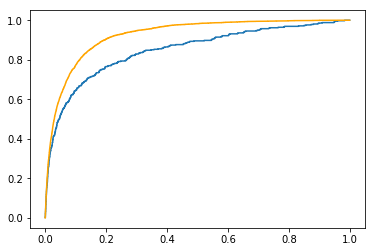

In [242]:
print('train:', roc_auc_score(y_true=y0.astype(int), 
                              y_score=pred_0))
print('test:', roc_auc_score(y_true=yt.astype(int), 
                             y_score=pred_t))
tpr, fpr, thr = roc_curve(y_true=yt.astype(int), 
                          y_score=pred_t)
plt.plot(tpr, fpr)
tpr, fpr, thr = roc_curve(y_true=y0.astype(int), 
                          y_score=pred_0)
plt.plot(tpr, fpr, color='orange')

In [237]:
lst = []
lst2 = []
# mdl._update_network(Xt)
for x in Xt['_id'].iloc[:100]:
    x = mdl._network[x]
    recs, prbs = mdl._recommend(x, 6)
    lst.append(sum(1 if rec in (x.in_ | x.out_) else 0 for rec in recs))
    lst2.append(lst[-1]/max(1, min(
        len((x.in_ | x.out_) & set(mdl._network.nodes.keys())), 
            len(recs))))

KeyboardInterrupt: 

In [230]:
np.mean(lst2)

0.26376010737628386

In [226]:
mdl._network.shape

'(nodes x 2432), (edges x 6482)'

In [ ]:
splitter = EdgeSplitter()
X0, Xt, E0, Et = splitter.split(X, E, 5.0)
y0, yt = E0['edge'], Et['edge']
for e in (E0,Et): e.drop('edge', axis=1, inplace=True)

In [ ]:
nodes = {Node(x) for _, x in X0.iterrows()}
network = Network(nodes)
for attr in ('topics', 'title', 'abstract'):
    network._fit_nlp(attr)

In [ ]:
for attr in ('topics','title','abstract','year','authors','n_authors'):
    E0[f'{attr}_simimilarity'] = [network.compare(row[0],row[1], attr) for _,row in E0.iterrows()]
E0.fillna(0, inplace=True)

In [ ]:
mdl = GradientBoostingClassifier(n_estimators=5000, subsample=0.9, max_features='sqrt', max_depth=1)
mdl.fit(E0.drop(['src','dst'], axis=1), y0.astype(int))

In [ ]:
network.add_nodes(Node(x) for _, x in Xt.iterrows())
for attr in ('topics','title','abstract','year','authors','n_authors'):
    Et[f'{attr}_simimilarity'] = [network.compare(row[0],row[1], attr) for _,row in Et.iterrows()]
Et.fillna(0, inplace=True)

In [ ]:
print('train:', roc_auc_score(y_true=y0.astype(int), 
                              y_score=mdl.predict_proba(E0.drop(['src','dst'], axis=1))[:, 1]))
print('test:', roc_auc_score(y_true=yt.astype(int), 
                             y_score=mdl.predict_proba(Et.drop(['src','dst'], axis=1))[:, 1]))
tpr, fpr, thr = roc_curve(y_true=yt.astype(int), 
                          y_score=mdl.predict_proba(Et.drop(['src','dst'], axis=1))[:, 1])
plt.plot(tpr, fpr)
tpr, fpr, thr = roc_curve(y_true=y0.astype(int), 
                          y_score=mdl.predict_proba(E0.drop(['src','dst'], axis=1))[:, 1])
plt.plot(tpr, fpr, color='orange')